**This notebook expands on the group project done by Comfort Group 1, more specifically the thermal comfort model created for Australia.**

# 1. Introduction

## 1.1. Neutral Thermal Sensation vs Preferred Thermal Sensation#

It is commonly assumed that a perceived neutral thermal sensation of 0 is also a comfortable thermal sensation, but recent studies have refuted that claim, showing how the preferred thermal sensation is not always a neutral thermal sensation (e.g. Shahzad & Rijal, 2019). This is as occupants might still prefer a change in thermal sensation even though he/she is already currently experiencing a neutral thermal sensation. For example, an occupant might recognise room temperature as a neutral thermal sensation, but prefer to be in an air-conditioned room which he/she recognises to be colder than neutral thermal sensation. 

As such, the perceived thermal sensation is not neccessarily the same as the occupant's preferred thermal sensation. When designing a model for indoor thermal comfort, it is important to consider both preferred thermal sensation and perceived thermal sensation. In our Group Project, we only looked at the 'Thermal sensation' as the response variable, but this is only the perceived thermal comfort and not the preferred thermal comfort.

## 1.2. Effect of Seasons on Perceived and Preferred Thermal Sensations

Now that we have established the difference between perceived and preferred thermal sensation, we can then examine how seasons affect both perceived and preferred thermal sensations **indoors**. During the different seasons, the thermal sensation outdoors will vary greatly, as each season brings about very differing environmental parameters such as air temperature, wind velocity etc etc. Thus, when going indoors into a thermal environment that is controlled by the building's air conditioning unit, will seasons still affect perceived and preferred thermal sensation, **given that the building's thermal environment has stayed the same across all seasons**.

For example, in Summer, the weather outside could be so hot that upon entering an air-conditioned building, the occupant might want an especially cooling sensation (imagine the pleasures of eating an icecream on a sweltering hot day), and thus his preferred thermal sensation might be lower than in Winter, when the occupant is already so cold outdoors than he/she would want something cozy and warm indoors instead, and thus his preferred thermal sensation then might be higher.
Different seasons could also affect the occupant's perception of what is perceived neutral thermal sensation, even if the thermal environment of the building stays exactly the same across all seasons. For example, the occupant could have gotten used to the heat of Summer and has subconsiously adjusted his perceived neutral thermal sensation accordingly.

## 1.3. Hypothesis
Given that the thermal environment of a building stays constant throughout all seasons:  
1) The different seasons will affect both perceived and preferred thermal sensation  
2) Colder seasons such as Autumn and Winter will have opposite effects on perceived and preferred thermal sensation as compared to warmer seasons such as Spring and Summer 

### 1.3.1. Objectives
1) Is there a difference between neutral thermal sensation and preferred thermal sensation?  
2) Do seasons affect the **perceived** thermal sensation?  
3) Do seasons affect the **preferred** thermal sensation?

# 2. Preparation of Dataset

Before we start with the analysis, we need to first import the data from the provided Ashrae dataset. 

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv("/kaggle/input/ashrae-global-thermal-comfort-database-ii/ashrae_db2.01.csv")
df = pd.DataFrame(data)

The first thing that needs to be done is to check if all data entries have both Thermal sensation and Thermal preference data. The Thermal comfort field is also important, as it shows the magnitude of the thermal preference. For example, a thermal preference of 'cooler' and a thermal comfort of 1 would suggest that the person prefers a much cooler thermal sensation than what he/she currently has. This will be further explained in a later part of the notebook.

Another important thing to note is that not all data entries have recorded Radiant Temperature values. While the Mean Radiant Temperature (MRT) is often assumed to be equal to Air Temperature during thermal comfort studies in air-conditioned buildings, studies have found that this assumption could be erronous and lead to significant error in determination of thermal comfort (Chaudhuri et al., 2016).

As such, we will first be filtering out the data entries that do not contain Thermal sensation, Thermal preference, Thermal comfort and Radiant temperature. Of course, as we are examining the impact of seasons, the Season should also be present.

In [ ]:
df = df.dropna(subset = ['Season', 'Radiant temperature (C)', 'Thermal sensation',
                         'Thermal comfort', 'Thermal preference'])
df['Country'].value_counts()

Here, we can see that Australia has the highest number of data entries with the required information as listed above. We will thus be proceeding with Australia as we have already created an intial thermal sensation model for it, so we know which parameters from the Ashrae dataset are important for predicting thermal sensation (just to reiterate, this is an extension of our group project).

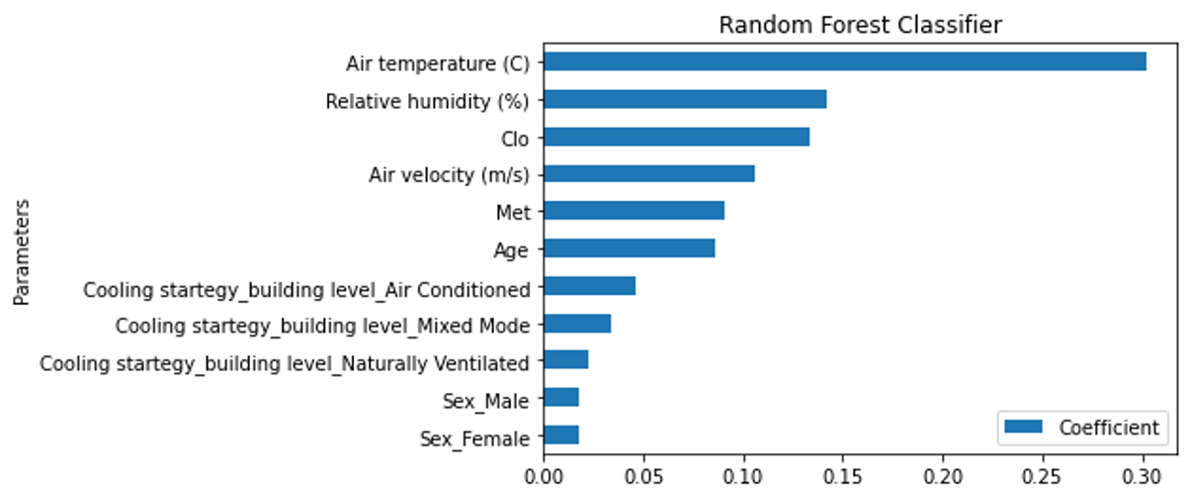
Fig. 1. Graph of feature importances of the Australia thermal sensation model. Taken from BPS5229 Group Project.

In the case of Australia (Fig. 1), past results have shown that Air temperature, Relative humidity, Clo, Air velocity, Met, Age, Cooling strategy, and Sex have non-negligible importance in the prediction of thermal sensation values in Australia. As such, we will also be focusing on these parameters as the explanatory variables (together with Season, Radiant temperature as mentioned earlier). How the addition of Radiant Temperature affects the model will have to be determined in a new model.

The filtering of cooling strategy to only include 'Air Conditioned' is extremely important here. This is as we are working under the assumption that the indoor thermal environment is not affected in anyway by the outdoor thermal environment that is being drastically affected by the seasons. As such, an 'Air Conditioned' cooling strategy ensures that the indoors thermal environment is kept independent and isolated from the outdoor thermal environment. Other cooling strategies such as 'Naturally Ventilated' or 'Mixed Mode' could be affected by the outdoors thermal environment.

In [ ]:
df = df[['Country', 'Season', 'Radiant temperature (C)', 'Thermal sensation', 
         'Thermal preference', 'Thermal comfort', 'Air temperature (C)', 
         'Relative humidity (%)', 'Clo', 'Air velocity (m/s)','Met', 'Age', 
         'Cooling startegy_building level', 'Sex']]
df = df[df['Country'] == 'Australia']
df_Aus = df[df['Cooling startegy_building level'] == 'Air Conditioned']
df_Aus = df_Aus.dropna()
df_Aus['Season'].value_counts()

After some basic data cleaning as detailed above, we can then look at the seasons that are represented in the data. As we can see from the value counts, only 3 seasons are represented. Although Spring is not represented in this dataset, we can still continue to study the effects of the other 3 seasons.

Next, we will need to round all the thermal sensation and thermal comfort values to integers for the sake of uniformity, as some recorded values are not in integers.

In [ ]:
df_Aus['Thermal comfort'] = df_Aus['Thermal comfort'].map(lambda x : int(x))
df_Aus['Thermal sensation'] = df_Aus['Thermal sensation'].map(lambda x : int(x))

# df_Aus = df_Aus.round({'Thermal sensation': 0, 'Thermal comfort': 0})

# 3. Objective (1) - Difference Between Neutral Thermal Sensation and Preferred Thermal Sensation

## 3.1. Calculation of Preferred Thermal Sensation

We then look to complete the first objective of this notebook, which is to determine if there is a difference between neutral thermal sensation and preferred thermal sensation. To help us with this, the dataset has 3 parameters which we can use, namely 'Thermal sensation', which is the perceived thermal sensation, 'Thermal preference', and 'Thermal comfort'.

However, as 'Thermal preference' has been recorded as just either 'cooler', 'warmer', or 'no change', it is not possible to know the magnitude of the thermal preference. Does the person with a cooler 'Thermal preference' prefer something slightly cooler, or something much cooler than his current thermal sensation? This is where 'Thermal comfort' comes into the picture, as it has been recorded on a scale from 1 to 6, with 1 being the least thermal comfortable and 6 being the most thermal comfortable. It is thus assumed that the further a person's 'Thermal comfort' differs from the ideal value of 6, the further the occupant is from his/her ideal thermal sensation, and thus would have a greater magnitude of 'Thermal preference'. For example, a person with a 'Thermal preference' of 'cooler' and a 'Thermal comfort' of 1 would want a thermal sensation much cooler than what he/she is currently experiencing, while a person with a 'Thermal preference' of 'cooler' and a 'Thermal comfort' of 5 would want a thermal sensation that is only slightly cooler than what he/she is currently experiencing.

As such, it is proposed that the 'Preferred thermal sensation' be based on 3 parameters, 1) the current perceived thermal sensation, 2) the direction of thermal preference (e.g. cooler, warmer or none), and 3) the magnitude of thermal preference (based on extent of deviation from ideal thermal comfort of 6).  
We can then estimate a 'Preferred thermal sensation' as such:  

'Thermal sensation' + 'Direction' * (6 - 'Thermal comfort')  

Where 'Direction' is 1 if thermal preference is 'warmer', -1 if thermal preference is 'cooler', and 0 if thermal preference is 'no change'.
If the calculated 'Preferred thermal sensation' is smaller than -3 or greater than 3, it will be set as -3 or 3 respectively.

**Example 1:**  
'Thermal sensation': 0, 'Thermal preference': cooler, 'Thermal comfort': 1  
'Preferred thermal sensation': 0 + (-1)*(6 - 1) = -5 = -3

**Example 2:**  
'Thermal sensation': -2, 'Thermal preference': warmer, 'Thermal comfort': 3  
'Preferred thermal sensation': -2 + (1)*(6 - 3) = 1

\* It is important to note that this method of calculating 'Preferred thermal sensation' has not been verified, and might not be the most accurate way of calculation. Future work needs to be done to find the most accurate way of calculating 'Preferred thermal sensation' from perceived 'Thermal sensation', 'Thermal preference' and 'Thermal comfort'.

To prepare for the calculation of the 'Preferred thermal sensation', we first need to map the 'Thermal preference' such that 'cooler' is -1, 'warmer' is 1, and 'no change' is 0.

In [ ]:
d = {'cooler': -1, 'warmer': 1, 'no change': 0}
df_Aus['Thermal preference'] = df_Aus['Thermal preference'].map(d)
df_Aus['Thermal preference'].head()

Now that the 'Thermal preference' is mapped accordinly, we can now proceed with the calculation of the 'Preferred thermal sensation'. As mentioned earlier, the 'Preferred thermal sensation' is bound by -3 and 3, just like the perceived 'Thermal sensation'.

In [ ]:
df_Aus['Preferred thermal sensation'] = df_Aus['Thermal sensation'] + (df_Aus['Thermal preference'] * (6 - df_Aus['Thermal comfort']))
df_Aus['Preferred thermal sensation'] = df_Aus['Preferred thermal sensation'].map(lambda x: int(max(min(x,3),-3)))
df_Aus['Preferred thermal sensation'].head()

In [ ]:
df_Aus['Preferred thermal sensation'].value_counts()

## 3.2. Comparison of Neutral Thermal Sensation and Preferred Thermal Sensation

Now that we have our calculated preferred thermal sensation values, we can then compare it against the neutral thermal sensation value of 0, to determine if there are any differences. If the preferred thermal sensation is the same as neutral thermal sensation, then a large number of preferred thermal sensation values should be 0.

We first start with a confusion matrix to visualise how different the two values are. Although the confusion matrix is more conventionally used to visualise errors in classification predictions, it can also be repurposed to see the differences between 2 series of data. This is also true for model scores such as f1_score, which can also be used for this purpose. The weighted f1 score is used as it is better suited for datasets with label inbalance (alot of thermal sensation of 0 values in this dataset), as compared to micro and macro f1 scores.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

length = len(df_Aus['Preferred thermal sensation'])
neutral_thermal = [0 for i in range(length)]
categories = np.array([-3,-2,-1,0,1,2,3])
cm = confusion_matrix(neutral_thermal, df_Aus['Preferred thermal sensation'])
np.seterr(divide='ignore', invalid='ignore')
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.imshow(cm_normalized, interpolation='nearest', cmap='Reds')
plt.title('Normalized Thermal Sensation Difference Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks,categories)
plt.yticks(tick_marks,categories)
plt.tight_layout()
plt.ylabel('Neutral thermal sensation')
plt.xlabel('Preferred thermal sensation')
plt.tight_layout()

print(f"Weighted f1 score: {round(f1_score(neutral_thermal, df_Aus['Preferred thermal sensation'], average='weighted'), 3)} (3dp)")

From the confusion matrix and weighted f1 score, we see that the neutral thermal sensation of 0 and the 'Preferred thermal sensation' actually differ quite significantly. Only around 45% of the 'Preferred thermal sensation' is actually 0, and the other half differs from the neutral thermal sensation.

Although a weighted f1 score of 0.624 is not bad, it still shows that there are differences between the two. Thus we can conclude that there is indeed a difference between the neutral thermal sensation of 0 and the 'Preferred thermal sensation', although the difference is not that big.

# 4. Objective (2) - Effect of Seasons on Perceived Thermal Sensation

The second objective of this notebook is to determine if the seasons play a part in affecting perceived 'Thermal sensation'. For example, during spring, an occupant could be satisfied with his thermal sensation in his office, but during winter, even though thermal conditions in the office have not changed, the person might perceive his office to be colder/hotter than usual.

In order to study this, we first need to split up the dataset into seasons.

In [ ]:
df_Spring = df_Aus[df_Aus['Season'] == 'Spring']
df_Summer = df_Aus[df_Aus['Season'] == 'Summer']
df_Autumn = df_Aus[df_Aus['Season'] == 'Autumn']
df_Winter = df_Aus[df_Aus['Season'] == 'Winter']

## 4.1. Improving on the Australia Model used for the Group Project

We start by comparing the perceived 'Thermal sensation' between the seasons against the whole dataset. As out group project did not use Radiant Temperature in our model (there weren't enough data entries for other countries containing that parameter), it is neccessary to create a new model taking Radiant Temperature into account. It is not only one of the parameters of thermal comfort as outline by Ashrae 55 guidelines, but studies such as Chaudhuri et al. (2016) have shown the importance of this parameter. Chaudhuri et al. (2016) found that while Radiant Temperature is very often assumed by other studies to be the same as Air Temperature, this incorrect assumption actually causes significant inaccuracy in the modelling of predicted thermal comfort.

The model will be trained with the combined data containing all 4 seasons. The perceived 'Thermal sensation' of each season will be compared against the model, to check if it is different from the predicted values. The 'Country' and 'Cooling startegy_building level' parameters are removed for this model as it contains all the same values as 'Australia' and 'Air Conditioned' respectively. The 'Season' parameter is removed so that the model is unable to know which data entry is for which season. This allows us to clearly see the differences between seasons later on.

In [ ]:
df_Aus = pd.get_dummies(df_Aus.drop(columns = ['Country', 'Season', 
                                               'Cooling startegy_building level']))
df_Aus.head()

In [ ]:
response = df_Aus[['Thermal sensation', 'Thermal preference', 'Thermal comfort', 
                   'Preferred thermal sensation']].reset_index(drop=True)
df_Aus = df_Aus.drop(columns = ['Thermal sensation', 'Thermal preference', 'Thermal comfort', 
                                'Preferred thermal sensation'])

Splitting the dataset into 70% train and 30% test:

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(df_Aus, response['Thermal sensation'], test_size=0.3, random_state=2)

I am using RandomizedSearchCV instead of GridSearchCV this time for model hyperparameter tuning, as RandomizedSearchCV is much faster. However, in the interest of accuracy, I have set it to run 20 iterations instead of the default 10. As such, some of the models will still take quite a while to tune (My run took 10mins).   
\* **Do note that if you do not have time to run this cell, I have recorded the results of my run below. Due to the nature of RandomizedSearchCV, the results of my run will most likely be different from yours.**

Through this model hyperparameter tuning, we are able to determine which model is the most accurate for predicting our data, using the k-fold score. While the f1score only lets us know the accuracy of 1 pre-defined train set in predicting 1 pre-defined test set, k-fold instead estimates how the model is expected to perform in general when used to make predictions on data not used during the training of the model. As such, k-fold is arguably the more important score when making prediction models as we are doing, and we will be using it to determine which model is the best for each of the countries.

**Future work:**
* Use TensorFlow instead of Scikit-learn so that TPU acceleration can be used.  
* Although XGBoost is probably the best ML algorithm to use here, I have chosen **not** to use it as it requires a long time to tune the model properly, which would take far too long on Kaggle. XGBoost has been one of the most popular ML algorithms used on Kaggle due to its efficiency and performance. Without going into too much details, XGBoost is a decision-tree based ensemble ML algorithm, and it provides increased performance over the RandomForest algorithm as the XGBoost algorithm also uses an optimised Gradient Boosting algorithm to avoid overfitting and minimise the errors in sequential models.

In [ ]:
# Future work: convert to tensorflow for TPU support

# from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import RandomizedSearchCV
import time

# To time how long this hyperparameter tuning takes
start = time.time()

models = [RandomForestClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), 
          MLPClassifier(), AdaBoostClassifier(), SVC(), DummyClassifier()]
modelnames = {models[0]:'model_rf', models[1]:'model_kn', models[2]:'model_dt', 
              models[3]:'model_mlp', models[4]:'model_abc', 
              models[5]:'model_svc', models[6]:'model_dc'}

parametersgrid = {'model_xgb': {'learning_rate': np.arange(0.01, 0.5, 0.02).tolist(),
                                'n_estimators': range(1000, 8000, 1000),
                                'max_depth': range(1, 20, 1),
                                'min_child_weight': range(1, 20, 1),
                                'gamma': np.arange(0, 0.7, 0.1).tolist(),
                                'subsample': np.arange(0.4, 1, 0.1).tolist(),
                                'colsample_bytree': np.arange(0.4, 1, 0.1).tolist(),
                                'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}, 
                  'model_rf': {'n_estimators': [1, 10, 20, 40, 70, 100, 150, 
                                                200, 250, 300, 500],  
                               'min_samples_leaf': range(1, 20, 1), 
                               'min_samples_split': range(1, 10, 1)}, 
                  'model_kn': {'n_neighbors': [1, 10, 20, 40, 70, 100, 150, 
                                               200, 250, 300, 500],  
                               'leaf_size': range(5, 100, 5),
                               'p': [1,2],
                               'weights': ['uniform', 'distance']}, 
                  'model_dt': {'min_samples_leaf': range(5, 100, 5),  
                               'min_samples_split': range(5, 100, 5)}, 
                  'model_mlp': {'activation': ['identity', 'logistic', 'tanh', 'relu'],  
                                'solver': ['lbfgs', 'sgd', 'adam'], 
                                'max_iter': [2000]}, 
                  'model_abc': {'n_estimators': [1, 10, 20, 40, 50, 70, 80, 100, 150,
                                                 200, 250, 300, 500],  
                                'algorithm': ['SAMME', 'SAMME.R']}, 
                  'model_svc': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
                                'C': np.arange(0.2, 10, 0.2).tolist()}, 
                  'model_dc': {'random_state': [2]}}


for model in models:
    modelname = modelnames[model]
    print(f'Tuning {modelname}: ')
    grid = RandomizedSearchCV(model, parametersgrid[modelname], refit = True, verbose = 3, 
                              n_jobs = -1, n_iter = 20)
    grid.fit(features_train, target_train) 
    globals()[f'{modelname}_bestparams'] = grid.best_params_ 
    grid_predictions = grid.predict(features_test)
    globals()[f'{modelname}_f1score'] = f1_score(target_test, grid_predictions, 
                                                 average = 'weighted')
    globals()[f'{modelname}_kfoldscore'] = grid.best_score_
    
    # This 2s sleep is here to ensure that the outputs are in the correct order,
    # because the output for each loop used to overlap with each other.
    time.sleep(2)


for model in models:
    modelname = modelnames[model]
    print(f"{modelname} best parameters: {globals()[f'{modelname}_bestparams']}")
    print(f"{modelname} best f1 score: {globals()[f'{modelname}_f1score']}")
    print(f"{modelname} best k-fold score: {globals()[f'{modelname}_kfoldscore']}" + '\n')
    
temp = (time.time() - start)
hours = int(temp//3600)
temp = temp - 3600*hours
minutes = int(temp//60)
seconds = round(temp - 60*minutes, 3)
print(f'Time taken: {hours}hrs, {minutes}mins, {seconds}secs')


### Recorded best parameter, f1 score, k-fold score for all tuned models:
#### Please note that these results will probably be different from yours due to the nature of RandomizedSearchCV

model_rf best parameters: {'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 15}  
model_rf best f1 score: 0.33491258199813545  
model_rf best k-fold score: 0.4807843137254902

model_kn best parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 500, 'leaf_size': 70}  
model_kn best f1 score: 0.29449477002010743  
model_kn best k-fold score: 0.4768627450980392

model_dt best parameters: {'min_samples_split': 45, 'min_samples_leaf': 95}  
model_dt best f1 score: 0.29449477002010743  
model_dt best k-fold score: 0.4768627450980392

model_mlp best parameters: {'solver': 'sgd', 'max_iter': 2000, 'activation': 'logistic'}  
model_mlp best f1 score: 0.29449477002010743  
model_mlp best k-fold score: 0.4768627450980392

model_abc best parameters: {'n_estimators': 1, 'algorithm': 'SAMME.R'}  
model_abc best f1 score: 0.29449477002010743  
model_abc best k-fold score: 0.476078431372549

model_svc best parameters: {'kernel': 'linear', 'C': 5.8}  
model_svc best f1 score: 0.29449477002010743  
model_svc best k-fold score: 0.4768627450980392

model_dc best parameters: {'random_state': 2}  
model_dc best f1 score: 0.3150189299802674  
model_dc best k-fold score: 0.3035294117647059

Time taken: 0hrs, 9mins, 49.922secs

As we can see from the scores above, the RandomForestClassifier (model_rf) has the highest f1 and k-fold scores. This shows that the RandomForestClassifier model should be the most accurate (out of all the models tested) when predicting thermal sensation. As such, we will be proceeding with the RandomForestClassifier for the model.

Although the k-fold score is really not great at 0.48, it is still much higher than the baseline Dummy Classifier, and it is already a substantial improvement over the Australia model created during the Group Project, which had a k-fold score of 0.38, while the Brazil and India models created during the Group Project had much higher k-fold scores of 0.65 and 0.56 respectively. 

This suggests that the relatively lower accuracy could be due to the Australia data, but this is not in the scope of this notebook.

## 4.2. Comparing how Seasons Differ from Predicted Perceived Thermal Sensation Values

Now that we have a (hopefully) more accurate model for perceived 'Thermal sensation' values in Australia, we can then proceed to compare how the perceived thermal sensations for the different seasons differ from the predicted values. Remember that the model was not allowed to know which data entry came from which season, and as such, it cannot adapt to take into account the differences caused by the different seasons. Thus, if there are indeed differences caused by the seasons, then it should be seen as the difference between the observed and predicted values of thermal sensation for that season.

Training the model, using the best hyperparameters found during hyperparameter tuning earlier on.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier

au_model = RandomForestClassifier(n_estimators = 40, min_samples_split = 4, 
                                  min_samples_leaf = 15)
au_model.fit(features_train, target_train)
kf = KFold(n_splits=5)
y_pred = au_model.predict(features_test)

weightedf1 = f1_score(target_test, y_pred, average = 'weighted', labels=np.unique(y_pred))
print(f'weighted f1 score: {round(weightedf1, 2)}')

scores = cross_val_score(au_model, features_train, target_train, cv=kf)

avg_score = np.mean(scores)
print(f'kfold score: {round(avg_score, 2)}')

from sklearn.metrics import classification_report
print(classification_report(target_test, y_pred, labels=np.unique(y_pred)))

from tabulate import tabulate
print(tabulate({'Variables': list(df_Aus.columns), 'Coeff': au_model.feature_importances_}, 
               headers="keys"))

In [ ]:
rfdata = {'Parameters': list(df_Aus.columns), 'Coefficient': au_model.feature_importances_}
rfdatadf = pd.DataFrame(rfdata)
rfdatadf = rfdatadf.sort_values('Coefficient')
rfdatadf.plot.barh(x = 'Parameters', y = 'Coefficient', 
                   title = 'Random Forest Classifier Features Importances')

Now, to test the observed value of perceived thermal sensations in each season against the predicted value of perceived thermal sensation from the model. As mentioned earlier, the differences between observed and predicted should be the effect of the season on perceived thermal sensation.

In [ ]:
# Dropping the 'Season' parameter as it is no longer important. I.e all data entries in df_Summer will already definitely be in the Summer Season.
df_Summer = df_Summer.drop(columns = ['Season'])
df_Autumn = df_Autumn.drop(columns = ['Season'])
df_Winter = df_Winter.drop(columns = ['Season'])

In [ ]:
def plot_cm(observed, predicted):
    categories = np.array([-3,-2,-1,0,1,2,3])
    cm = confusion_matrix(observed, predicted, labels = categories)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)
    plt.imshow(cm_normalized, interpolation='nearest', cmap='Reds')
    plt.title('Normalized Classification Error Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks,categories)
    plt.yticks(tick_marks,categories)
    plt.tight_layout()
    plt.ylabel('Observed values')
    plt.xlabel('Predicted values')
    plt.tight_layout()
    print(f"Weighted f1 score: {round(f1_score(observed, predicted, average='weighted'), 3)} (3dp)")

### For Summer:

In [ ]:
df_Summer_train = df_Summer[['Radiant temperature (C)', 'Air temperature (C)', 
                             'Relative humidity (%)', 'Clo', 'Air velocity (m/s)', 
                             'Met', 'Age', 'Sex']].reset_index(drop=True)
df_Summer_train = pd.get_dummies(df_Summer_train)
df_Summer_pred = au_model.predict(df_Summer_train)

df_Summer_test = df_Summer['Thermal sensation']

plot_cm(df_Summer_test, df_Summer_pred)

cm = confusion_matrix(df_Summer_test, df_Summer_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm_normalized)

### For Autumn:

In [ ]:
df_Autumn_train = df_Autumn[['Radiant temperature (C)', 'Air temperature (C)',
                             'Relative humidity (%)', 'Clo', 'Air velocity (m/s)',
                             'Met', 'Age', 'Sex']].reset_index(drop=True)
df_Autumn_train = pd.get_dummies(df_Autumn_train)
df_Autumn_train['Sex_Male'] = 0
df_Autumn_pred = au_model.predict(df_Autumn_train)

df_Autumn_test = df_Autumn['Thermal sensation']

plot_cm(df_Autumn_test, df_Autumn_pred)

cm = confusion_matrix(df_Autumn_test, df_Autumn_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm_normalized)

### For Winter:

In [ ]:
df_Winter_train = df_Winter[['Radiant temperature (C)', 'Air temperature (C)',
                             'Relative humidity (%)', 'Clo', 'Air velocity (m/s)',
                             'Met', 'Age', 'Sex']].reset_index(drop=True)
df_Winter_train = pd.get_dummies(df_Winter_train)
df_Winter_pred = au_model.predict(df_Winter_train)

df_Winter_test = df_Winter['Thermal sensation']

plot_cm(df_Winter_test, df_Winter_pred)

cm = confusion_matrix(df_Winter_test, df_Winter_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm_normalized)

## 4.3. Rerunning With Default 'min_samples_leaf' Value

The confusion matrices for all 3 seasons look very weird. Almost all the predicted values are 0s, which could be because of the large number of thermal sensation = 0 in the Australia dataset. A quick check of the classification report when training the model shows that the model is indeed predicting almost everything as having a thermal sensation of 0, which is definitely not acceptable. Thus, this could be a limitation of the RandomForestClassifier model. Even though the k-fold scores of the RandomForestClassifier is higher than the other models, it does not always mean that it is the most appropriate model to use.

One thing that I noticed is that the min_samples_leaf hyperparameter is abnormally high at 15. Usually a high min_samples_leaf value results in reduced variance and higher levels of bias, which is what we are observing in the current RandomForestClassifier model. As such, I tried to use the default value of 1 for min_samples_leaf instead. Hopefully the model with a lower min_samples_leaf value will exhibit greater variance in the prediction, instead of just predicting almost everything to have a thermal sensation of 0.

In [ ]:
au_model_rfdefault = RandomForestClassifier(n_estimators = 40, min_samples_split = 4, 
                                            min_samples_leaf = 1, random_state = 2)
au_model_rfdefault.fit(features_train, target_train)

df_Summer_pred = au_model_rfdefault.predict(df_Summer_train)
df_Winter_pred = au_model_rfdefault.predict(df_Winter_train)
df_Autumn_pred = au_model_rfdefault.predict(df_Autumn_train)

### For Summer:

In [ ]:
plot_cm(df_Summer_test, df_Summer_pred)
cm = confusion_matrix(df_Summer_test, df_Summer_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

### For Autumn:

In [ ]:
plot_cm(df_Autumn_test, df_Autumn_pred)
cm = confusion_matrix(df_Autumn_test, df_Autumn_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

### For Winter:

In [ ]:
plot_cm(df_Winter_test, df_Winter_pred)
cm = confusion_matrix(df_Winter_test, df_Winter_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

While the confusion matrices can give us a rough idea of how the errors in classification look like, we also need to calculate the percentage of observed values that are less than predicted, as well as the percentage of observed values that are more than predicted.

In [ ]:
# Calculates how many observed values are less than predicted and how many are more than predicted
def countdiff(observed, predicted):
    under_count = 0
    over_count = 0
    observed = observed.tolist()
    predicted = predicted.tolist()
    for i in range(len(observed)):
        if observed[i] < predicted[i]:
            under_count += 1
        elif observed[i] > predicted[i]:
            over_count += 1
    under_perc = round(under_count*100/len(observed),3)
    over_perc = round(over_count*100/len(observed), 3)
    return (under_perc, over_perc)

summercountdiff = countdiff(df_Summer_test, df_Summer_pred)
autumncountdiff = countdiff(df_Autumn_test, df_Autumn_pred)
wintercountdiff = countdiff(df_Winter_test, df_Winter_pred)


print(f'Summer: {summercountdiff[0]}% observed values less than predicted, {summercountdiff[1]}% observed values more than predicted.')
print(f'Autumn: {autumncountdiff[0]}% observed values less than predicted, {autumncountdiff[1]}% observed values more than predicted.')
print(f'Winter: {wintercountdiff[0]}% observed values less than predicted, {wintercountdiff[1]}% observed values more than predicted.')

In [ ]:
N = 3
ind = np.arange(N)  
width = 0.27

fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Graph of Differences in Observed and Predicted Values', size = 15)
yvals = [summercountdiff[0], autumncountdiff[0], wintercountdiff[0]]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [summercountdiff[1], autumncountdiff[1], wintercountdiff[1]]
rects2 = ax.bar(ind+width, zvals, width, color='g')

ax.set_ylabel('Percentages')
ax.set_xticks(ind+(0.5*width))
ax.set_xticklabels( ('Spring', 'Autumn', 'Winter') )
ax.legend( (rects1[0], rects2[0]), ('Observed < Predicted', 'Observed > Predicted') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.0*h, f'{round(h,2)}%',
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

The weighted f1 scores for all 3 seasons are all above 0.8, and the confusion matrices shows that the model is no longer predicting everything as 0, which is a welcome sight!

It is hard to tell spot any glaring differences from just looking at the confusion matrices. However, when counting the percentages of over and under predictions, we can see a difference between the seasons. For Summer and Winter, there is a greater number of observed values that are **less** than predicted values (Observed < Predicted) as compared to observed values that are **more** than predicted values (Observed > Predicted). This shows that for both Summer and Winter, the perceived thermal sensation appears to be slightly lower than expected. The opposite is true for Autumn, where there is a greater number of observed values that are **more** than predicted values (Observed > Predicted) as compared to observed values that are **less** than predicted values (Observed < Predicted). This shows that for Autumn, the perceived thermal sensation appears to be slighter higher than expected.
This result goes against the initial hypothesis, as Summer and Winter are completely opposite seasons, with one being the hottest season and one being the coldest season. Yet, both seasons exhibit the same behavior in terms of perceived thermal sensation.

It is also important to note that the percentages are well within the model margins of error, as the model accuracy is not that good for Australia.

# 5. Objective (3) - Effect of Seasons on Preferred Thermal Sensation

We can then look at the last objective of this notebook, which is to determine if the seasons affect preferred thermal sensation of occupants. We can use the same model in the previous section for this section as well, but train it to predict preferred thermal sensation instead of perceived thermal sensation.

## 5.1. Training of the Same Random Forest Model for Preferred Thermal Sensation

In [ ]:
from sklearn.model_selection import train_test_split
features_train1, features_test1, target_train1, target_test1 = train_test_split(df_Aus, response['Preferred thermal sensation'], test_size=0.3, random_state=2)

In [ ]:
au_model_rfdefault.fit(features_train1, target_train1)

df_Summer_pred1 = au_model_rfdefault.predict(df_Summer_train)
df_Winter_pred1 = au_model_rfdefault.predict(df_Winter_train)
df_Autumn_pred1 = au_model_rfdefault.predict(df_Autumn_train)
df_Summer_test1 = df_Summer['Preferred thermal sensation']
df_Winter_test1 = df_Winter['Preferred thermal sensation']
df_Autumn_test1 = df_Autumn['Preferred thermal sensation']

## 5.2. Comparing how Seasons Differ from Predicted Preferred Thermal Sensation Values

Similar to the previous section, we can now test the observed value of preferred thermal sensations in each season against the predicted value of preferred thermal sensation from the model. The differences between observed and predicted should be the effect of the season on preferred thermal sensation.

### For Summer:

In [ ]:
plot_cm(df_Summer_test1, df_Summer_pred1)
cm = confusion_matrix(df_Summer_test1, df_Summer_pred1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

### For Autumn:

In [ ]:
plot_cm(df_Autumn_test1, df_Autumn_pred1)
cm = confusion_matrix(df_Autumn_test1, df_Autumn_pred1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

### For Winter:

In [ ]:
plot_cm(df_Winter_test1, df_Winter_pred1)
cm = confusion_matrix(df_Winter_test1, df_Winter_pred1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

While the confusion matrices can give us a rough idea of how the errors in classification look like, we also need to calculate the percentage of observed values that are less than predicted, as well as the percentage of observed values that are more than predicted.

In [ ]:
summercountdiff1 = countdiff(df_Summer_test1, df_Summer_pred1)
autumncountdiff1 = countdiff(df_Autumn_test1, df_Autumn_pred1)
wintercountdiff1 = countdiff(df_Winter_test1, df_Winter_pred1)


print(f'Summer: {summercountdiff1[0]}% observed values less than predicted, {summercountdiff1[1]}% observed values more than predicted.')
print(f'Autumn: {autumncountdiff1[0]}% observed values less than predicted, {autumncountdiff1[1]}% observed values more than predicted.')
print(f'Winter: {wintercountdiff1[0]}% observed values less than predicted, {wintercountdiff1[1]}% observed values more than predicted.')

In [ ]:
N = 3
ind = np.arange(N)  
width = 0.27

fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Graph of Differences in Observed and Predicted Values', size = 15)
yvals = [summercountdiff1[0], autumncountdiff1[0], wintercountdiff1[0]]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [summercountdiff1[1], autumncountdiff1[1], wintercountdiff1[1]]
rects2 = ax.bar(ind+width, zvals, width, color='g')

ax.set_ylabel('Percentages')
ax.set_xticks(ind+(0.5*width))
ax.set_xticklabels( ('Spring', 'Autumn', 'Winter') )
ax.legend( (rects1[0], rects2[0]), ('Observed < Predicted', 'Observed > Predicted') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1.0*h, f'{round(h,2)}%',
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

Similar to confusion matrices for the perceived thermal sensation, it is hard to tell spot any glaring differences for preferred thermal sensation from just looking at the confusion matrices. However, when looking at the percentages of over and under predictions, we can see a difference between the seasons. For Summer, there is a greater number of observed values that are **less** than predicted values (Observed < Predicted) as compared to observed values that are **more** than predicted values (Observed > Predicted). This shows that for Summer, the preferred thermal sensation appears to be slightly lower than expected.

The opposite is true for Autumn and Winter, where there is a greater number of observed values that are **more** than predicted values (Observed > Predicted) as compared to observed values that are **less** than predicted values (Observed < Predicted). This shows that for Autumn and Winter, the preferred thermal sensation appears to be slighter higher than expected.

This result is in line with the original hypothesis, that the colder seasons such as Autumn and Winter affect the preferred thermal sensation in a different way than the hotter seasons such as Summer. In this case, it appears that in the colder seasons of Autumn and Winter, Australians tend to seek for hotter thermal sensations, and in warmer season of Summer, Australians tend to seek for colder thermal sensations. 

However, it is very important to note that the percentages are well within the model margins of error, as the model accuracy is not that good for Australia.

# 6. Conclusion

From our results, we can observe that:  
1. Neutral thermal sensation and Preferred thermal sensation are different
2. Perceived thermal sensation does not follow our hypothesis  
**a.** Although there are differences between seasons, both Summer and Winter exhibit similar trends, which is not in agreement with the hypothesis  
**b.** The differences in perceived thermal sensation are quite minimal and could potentially just be errors cause by inaccuracy in the model

3. Preferred thermal sensation follows hypothesis, but percentages well within margins of error  
**a.** The colder seasons (Winter and Autumn) exhibit similar differences as compared to predicted values  
**b.** The warmer season (Summer) exhibits differences to the predicted values that are opposite of the differences in **a**.  
**c.** The differences in preferred thermal sensation are quite minimal and could potentially just be errors cause by inaccuracy in the model

While the hypothesis predicted warmer and colder seasons to have significant but opposite effects on Perceived thermal sensation and Preferred thermal sensation, the results for Perceived thermal sensation disagrees with this hypothesis as Summer and Winter exhibit similar effects on Perceived thermal sensation. 

For Preferred thermal sensation, results appear to be in agreement with the hypothesis, but the results are still within the margin of error for the model. The results could be because during colder seasons, occupants might want to feel warmer and cozier indoors to get a respite from the cold, while during hotter seasons, occupants might want to feel indoor conditions that are more cooling than usual ,to get a respite from the heat.

However, at this stage, these are just promising but inconclusive results. Through this study, we are not able to confidently say that seasons affect either the Perceived thermal sensation or the Preferred thermal sensation. Instead, more work needs to be done in the future, such as to create a better model that is better able to predict Perceived thermal sensation and Preferred thermal sensation. A more accurate way of calculating Preferred thermal sensation also has to be devised and verified for its accuracy. With a more accurate model, we can then be more confident that any differences in results between seasons is because of the seasons and not because of errors in the model. 

However, Australia dataset appears to be a challenge for models to predict accurately. From the Group Project to this Individual Project, the Australia dataset has continued to throw unexpected results, and have poor accuracy for any models tried, as compared to other countries such as India and Brazil where the process is much smoother. One guess would be that the Australia data is very unbalanced with too many data points with a thermal sensation of 0. This is just an educated guess, but there is need to figure out what the issues really are to rectify them.

### References:

Chaudhuri, Tanaya & Soh, Yeng & Bose, Sumanta & Xie, Lihua & Li, Hua. (2016). On assuming Mean Radiant Temperature equal to Air Temperature during PMV-based Thermal Comfort Study in Air-conditioned Buildings. 10.1109/IECON.2016.7793073.  
Shahzad, Sally & Rijal, Hom. (2019). Preferred vs neutral temperatures and their implications on thermal comfort and energy use: Workplaces in Japan, Norway and the UK. Energy Procedia. 158. 3113-3118. 10.1016/j.egypro.2019.01.1007. 